In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import shutil
import joblib
import json

# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Set plotting size and style
sns.set(rc = {'figure.figsize':(16, 8)})
sns.set_style("darkgrid")

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder

# Model Selection
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor

# Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import LeaveOneOut

# Statistical Analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

import opendatasets as od
import tqdm as notebook_tqdm

In [2]:
# Define the desired path for the raw data folder
raw_data_folder = r"C:\Users\User\ml-zoomcamp\midterm_project\data\raw"

# Ensure the raw data folder exists
os.makedirs(raw_data_folder, exist_ok=True)

# Download the dataset into the raw data folder
dataset_url = 'https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset'
od.download(dataset_url, data_dir=raw_data_folder)

print(f"Dataset downloaded and stored in: {raw_data_folder}")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset


100%|██████████| 21.6k/21.6k [00:00<00:00, 1.27MB/s]


Dataset downloaded and stored in: C:\Users\User\ml-zoomcamp\midterm_project\data\raw


In [3]:
# Load the dataset
df = pd.read_csv(r"C:\Users\User\ml-zoomcamp\midterm_project\data\raw\gym-members-exercise-dataset\gym_members_exercise_tracking.csv")
df.head()

Age  Gender  Weight (kg)  Height (m)  Max_BPM  Avg_BPM  Resting_BPM  \
0   56    Male         88.3        1.71      180      157           60   
1   46  Female         74.9        1.53      179      151           66   
2   32  Female         68.1        1.66      167      122           54   
3   25    Male         53.2        1.70      190      164           56   
4   38    Male         46.1        1.79      188      158           68   

   Session_Duration (hours)  Calories_Burned Workout_Type  Fat_Percentage  \
0                      1.69           1313.0         Yoga            12.6   
1                      1.30            883.0         HIIT            33.9   
2                      1.11            677.0       Cardio            33.4   
3                      0.59            532.0     Strength            28.8   
4                      0.64            556.0     Strength            29.2   

   Water_Intake (liters)  Workout_Frequency (days/week)  Experience_Level  \
0                    3.5                              4                 3   
1                    2.1                              4                 2   
2                    2.3                              4                 2   
3                    2.1                              3                 1   
4                    2.8                              3                 1   

     BMI  
0  30.20  
1  32.00  
2  24.71  
3  18.41  
4  14.39

In [4]:
# Check the data types of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [5]:
# Transform column names: make lowercase, remove parentheses and content inside
df.columns = df.columns.str.lower().str.replace(r"\s*\([^)]*\)", "", regex=True).str.replace(" ", "_")
df.columns

Index(['age', 'gender', 'weight', 'height', 'max_bpm', 'avg_bpm',
       'resting_bpm', 'session_duration', 'calories_burned', 'workout_type',
       'fat_percentage', 'water_intake', 'workout_frequency',
       'experience_level', 'bmi'],
      dtype='object')

In [6]:
# Define a function to calculate the missing value summary
def missing_value_summary(data):
    # Calculate the number of missing values and their percentage
    missing_value = data.isnull().sum().reset_index()
    missing_value.columns = ['Variable', 'Number of Missing']
    missing_value['Percentage of Missing'] = (missing_value['Number of Missing'] / data.shape[0] * 100).round(2)

    # Sort the summary by the percentage of missing values in descending order
    missing_value = missing_value.sort_values(by='Percentage of Missing', ascending=False).reset_index(drop=True)

    return missing_value

In [7]:
# Display the missing value summary
missing_value_summary(df)

Variable  Number of Missing  Percentage of Missing
0                 age                  0                    0.0
1              gender                  0                    0.0
2              weight                  0                    0.0
3              height                  0                    0.0
4             max_bpm                  0                    0.0
5             avg_bpm                  0                    0.0
6         resting_bpm                  0                    0.0
7    session_duration                  0                    0.0
8     calories_burned                  0                    0.0
9        workout_type                  0                    0.0
10     fat_percentage                  0                    0.0
11       water_intake                  0                    0.0
12  workout_frequency                  0                    0.0
13   experience_level                  0                    0.0
14                bmi                  0                    0.0

No missing values.

In [8]:
# Check basic information about registration_data_test dataset
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print('='*40)
print ("Features : \n" ,df.columns.tolist())
print('='*40)
print ("Unique values :  \n",df.nunique())

Rows     :  973
Columns  :  15
Features : 
 ['age', 'gender', 'weight', 'height', 'max_bpm', 'avg_bpm', 'resting_bpm', 'session_duration', 'calories_burned', 'workout_type', 'fat_percentage', 'water_intake', 'workout_frequency', 'experience_level', 'bmi']
Unique values :  
 age                   42
gender                 2
weight               532
height                51
max_bpm               40
avg_bpm               50
resting_bpm           25
session_duration     147
calories_burned      621
workout_type           4
fat_percentage       239
water_intake          23
workout_frequency      4
experience_level       3
bmi                  771
dtype: int64


In [9]:
# Check summary statistics
df.describe().T

count        mean         std     min     25%     50%  \
age                973.0   38.683453   12.180928   18.00   28.00   40.00   
weight             973.0   73.854676   21.207500   40.00   58.10   70.00   
height             973.0    1.722580    0.127720    1.50    1.62    1.71   
max_bpm            973.0  179.883864   11.525686  160.00  170.00  180.00   
avg_bpm            973.0  143.766701   14.345101  120.00  131.00  143.00   
resting_bpm        973.0   62.223022    7.327060   50.00   56.00   62.00   
session_duration   973.0    1.256423    0.343033    0.50    1.04    1.26   
calories_burned    973.0  905.422405  272.641516  303.00  720.00  893.00   
fat_percentage     973.0   24.976773    6.259419   10.00   21.30   26.20   
water_intake       973.0    2.626619    0.600172    1.50    2.20    2.60   
workout_frequency  973.0    3.321686    0.913047    2.00    3.00    3.00   
experience_level   973.0    1.809866    0.739693    1.00    1.00    2.00   
bmi                973.0   24.912127    6.660879   12.32   20.11   24.16   

                       75%      max  
age                  49.00    59.00  
weight               86.00   129.90  
height                1.80     2.00  
max_bpm             190.00   199.00  
avg_bpm             156.00   169.00  
resting_bpm          68.00    74.00  
session_duration      1.46     2.00  
calories_burned    1076.00  1783.00  
fat_percentage       29.30    35.00  
water_intake          3.10     3.70  
workout_frequency     4.00     5.00  
experience_level      2.00     3.00  
bmi                  28.56    49.84

**Summary Statistics**

*Demographics:*
- Age: Mean of ~39 years (Range: 18–59 years).
- Gender: Binary (Male/Female).

*Physical Attributes:*
- Weight (kg): Mean of ~73.85 kg (Range: 40–129.9 kg).
- Height (m): Mean of ~1.72 m (Range: 1.5–2.0 m).
- BMI: Mean of ~24.91 (Range: 12.32–49.84).

*Workout Metrics:*
- Max_BPM: Mean of ~179.88 (Range: 160–199 BPM).
- Avg_BPM: Mean of ~143.77 (Range: 120–169 BPM).
- Calories_Burned: Mean of ~905.42 (Range: 303–1783).
- Session Duration: Mean of ~1.26 hours (Range: 0.5–2.0 hours).
- Fat_Percentage: Mean of ~24.98% (Range: 10%–35%).
- Water_Intake: Mean of ~2.63 liters/day (Range: 1.5–3.7 liters).

In [10]:
# Plot distributions for numerical features
def plot_distributions(data, features):
    for feature in features:
        plt.figure(figsize=(8, 5))
        sns.histplot(data[feature], kde=True, bins=30, color='blue')
        plt.title(f"Distribution of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Frequency")
        plt.show()

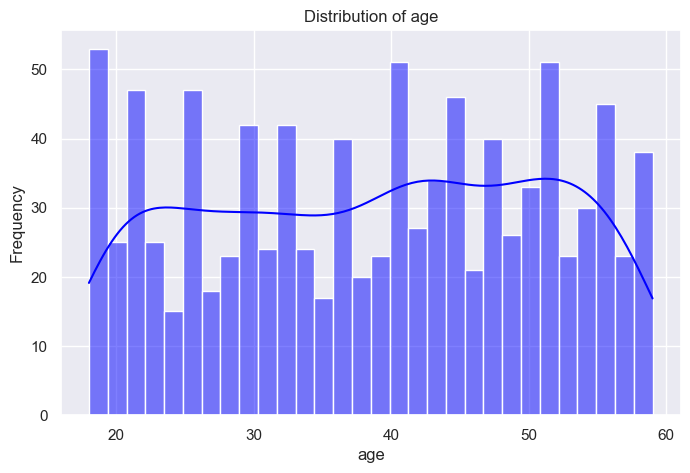

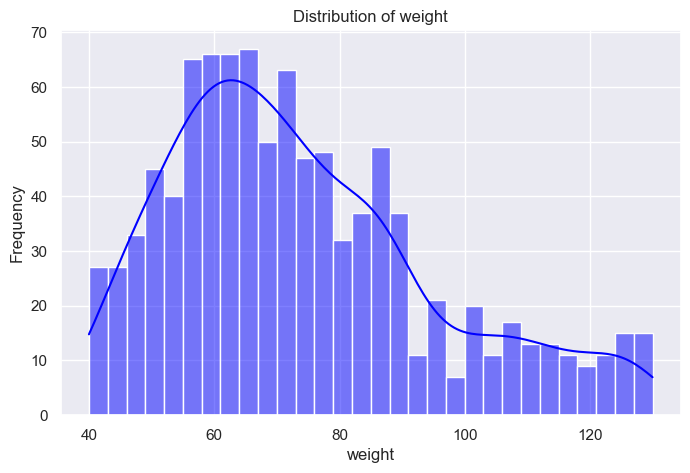

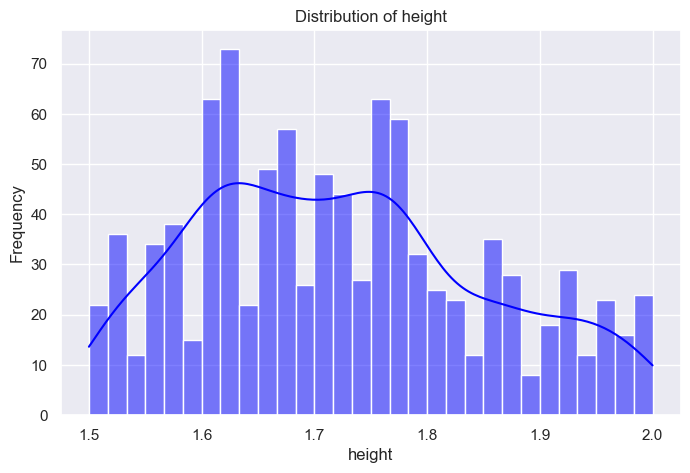

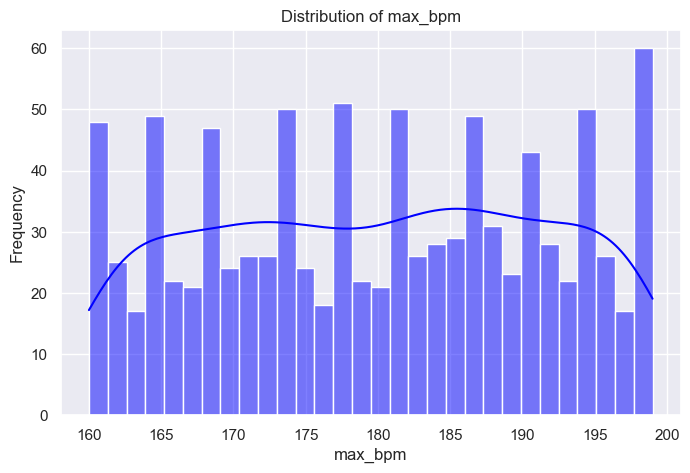

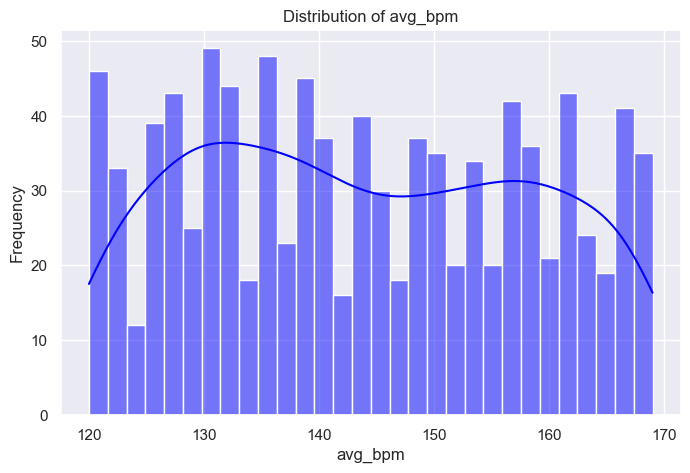

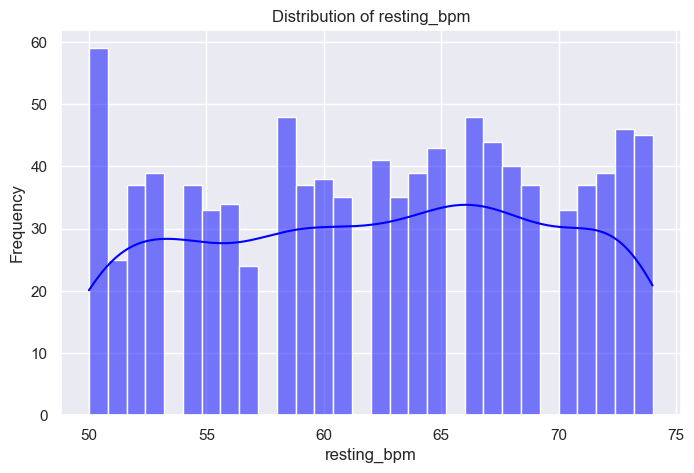

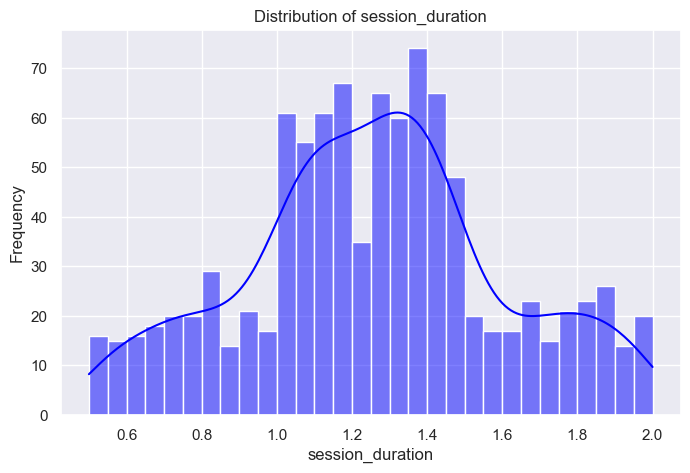

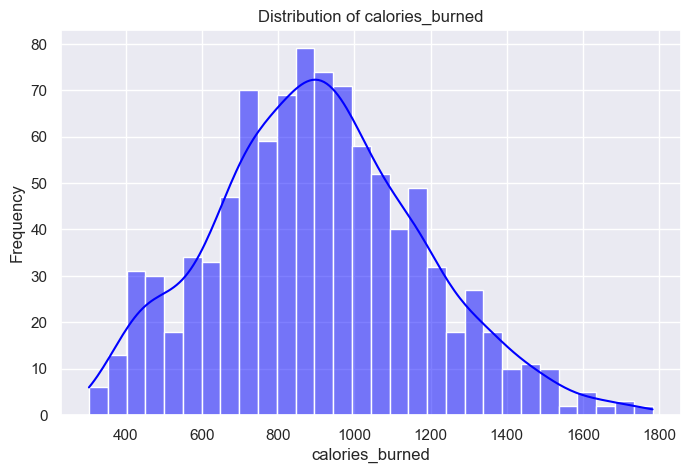

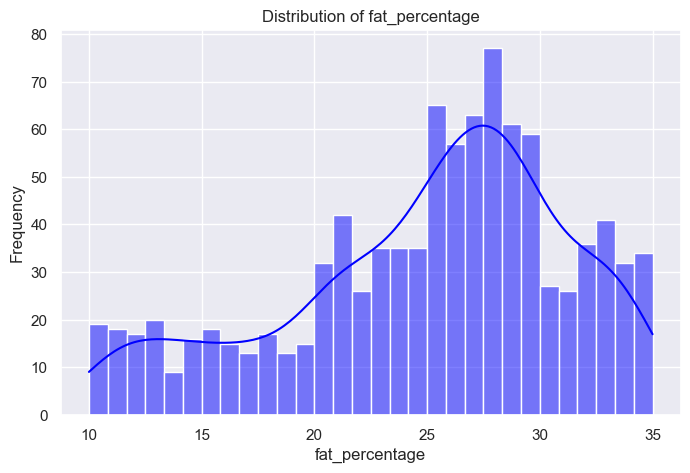

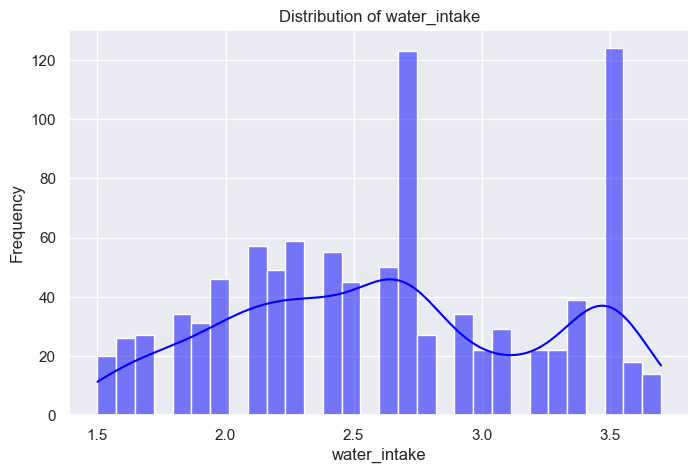

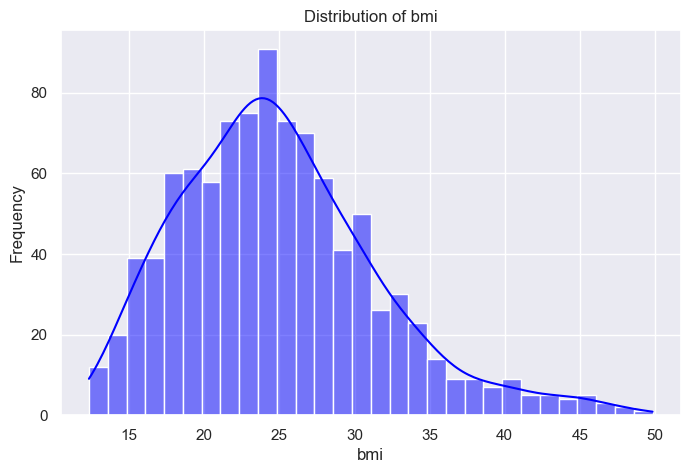

In [11]:
# Select numerical features for visualization
numerical_features = [
    'age', 'weight', 'height', 'max_bpm', 'avg_bpm', 'resting_bpm', 
'session_duration', 'calories_burned', 'fat_percentage', 'water_intake','bmi'
]

# Plot the distributions
plot_distributions(df, numerical_features)

In [12]:
# Bar plot for categorical features
def plot_categorical_distribution(data, feature):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=feature, data=data) 
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

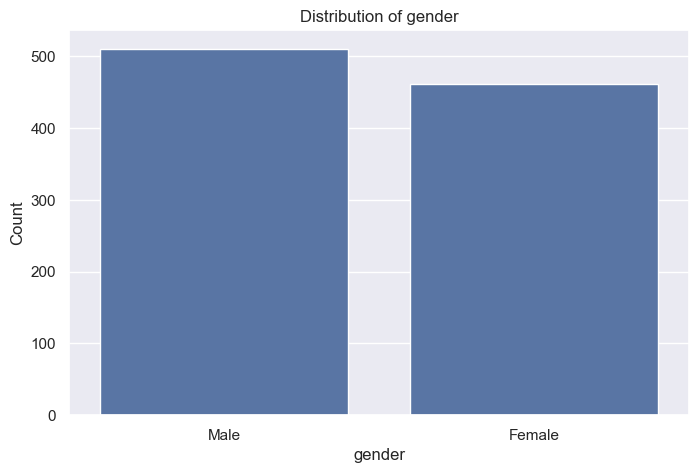

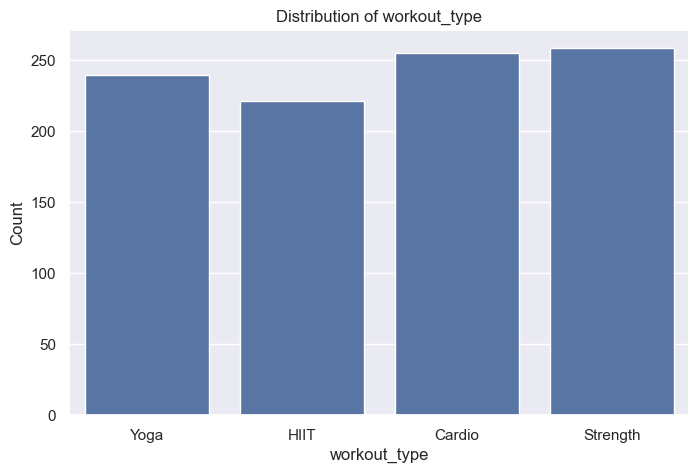

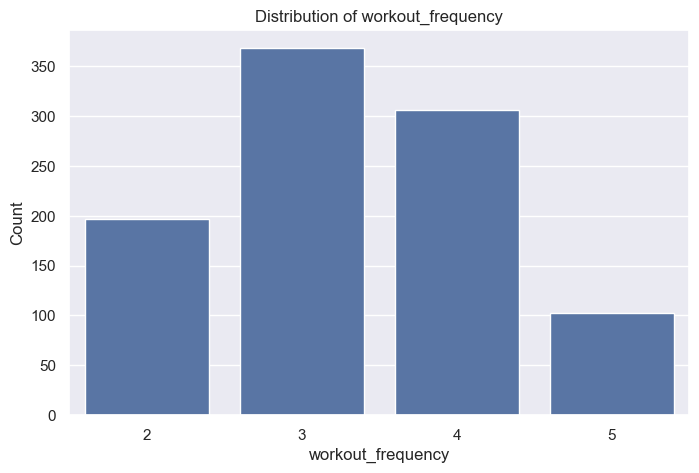

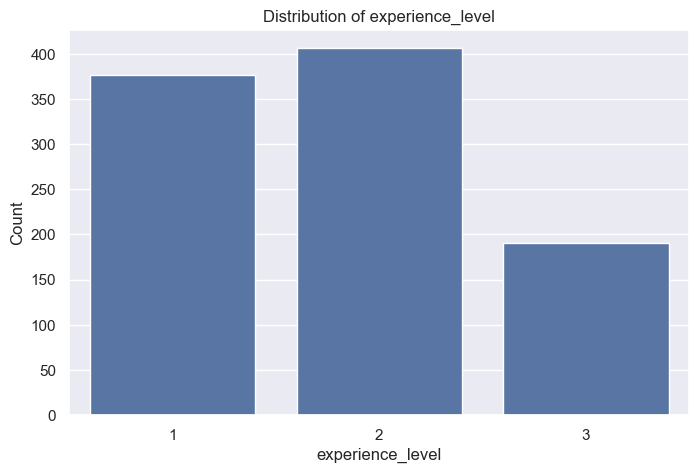

In [13]:
# Plot categorical features
categorical_features = ["gender", "workout_type", "workout_frequency", "experience_level"]

for feature in categorical_features:
    plot_categorical_distribution(df, feature)

In [14]:
# Plot boxplots for numerical features to identify outliers
def plot_boxplots(data, features):
    for feature in features:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=data[feature])
        plt.title(f"Boxplot of {feature}")
        plt.xlabel(feature)
        plt.show()

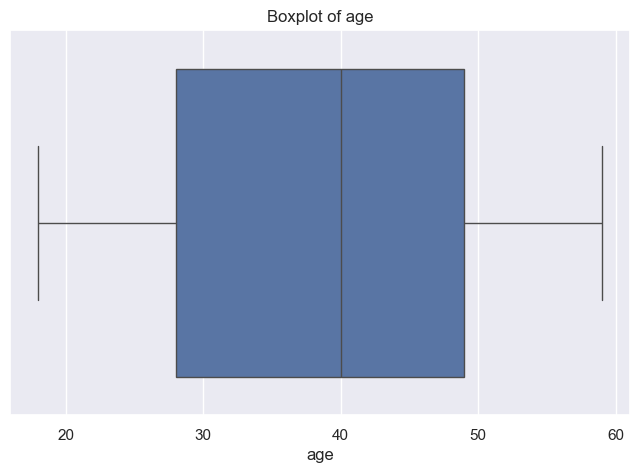

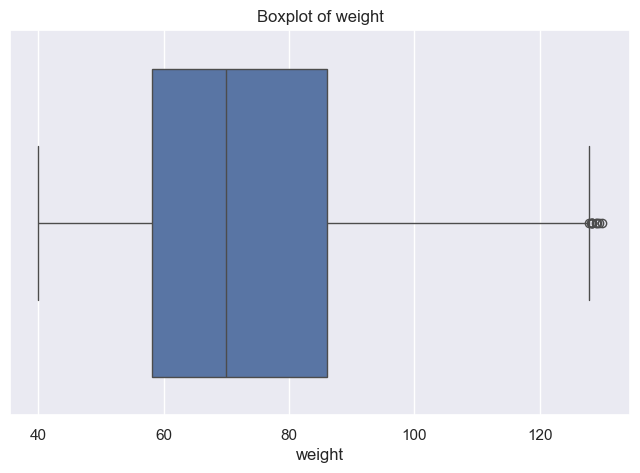

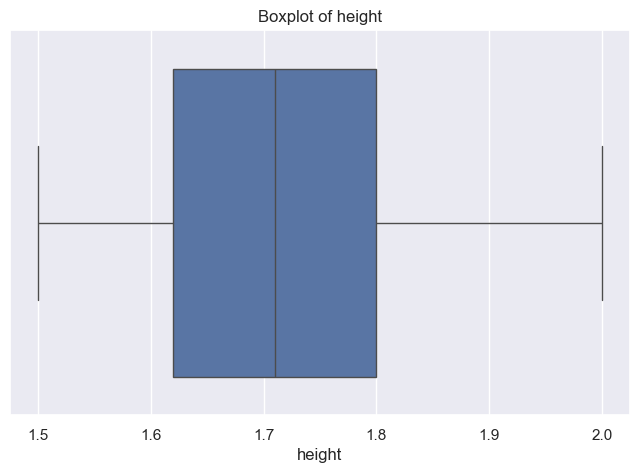

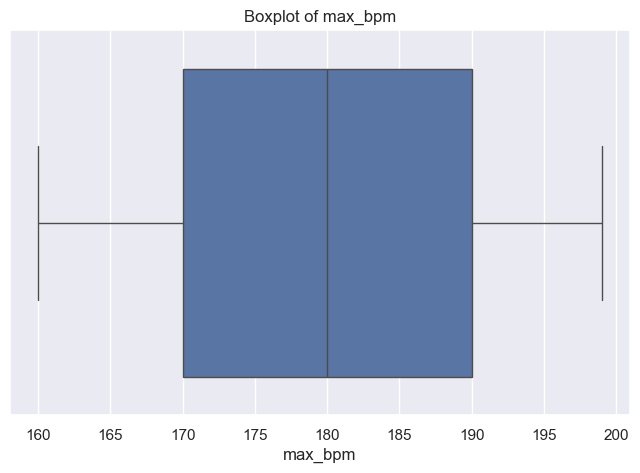

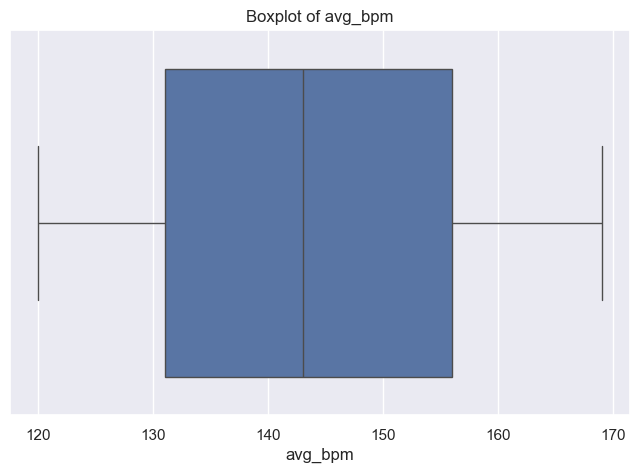

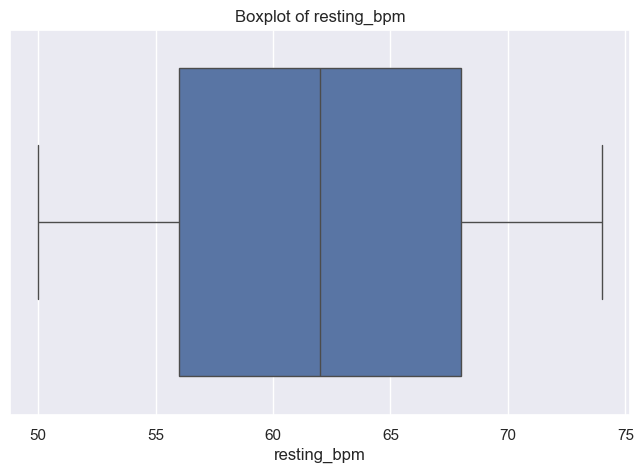

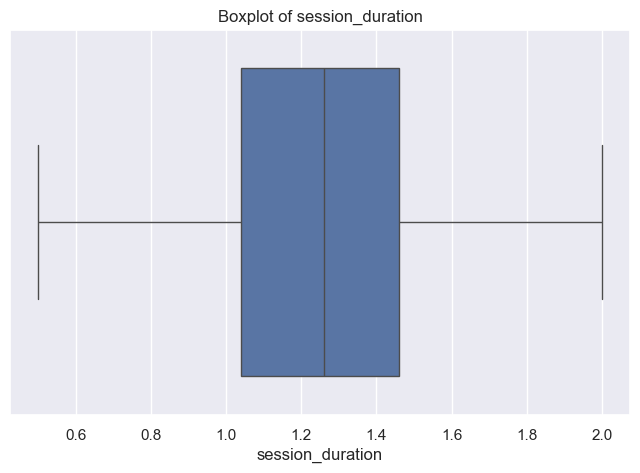

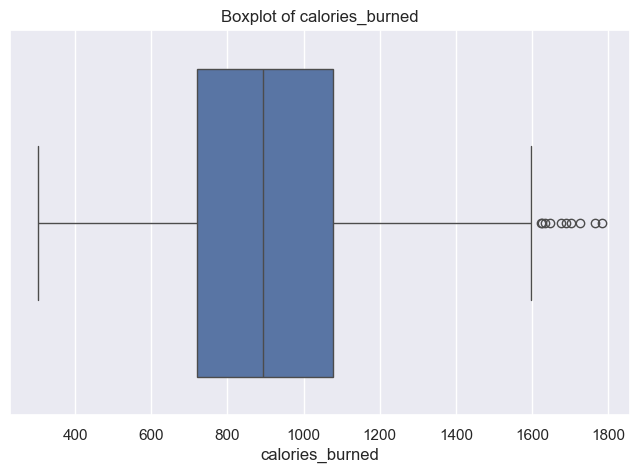

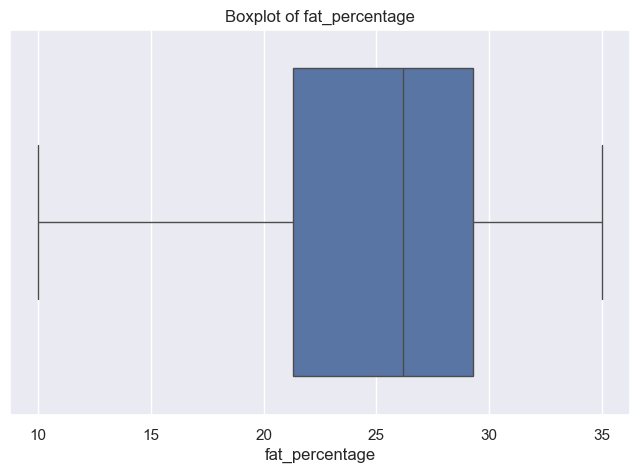

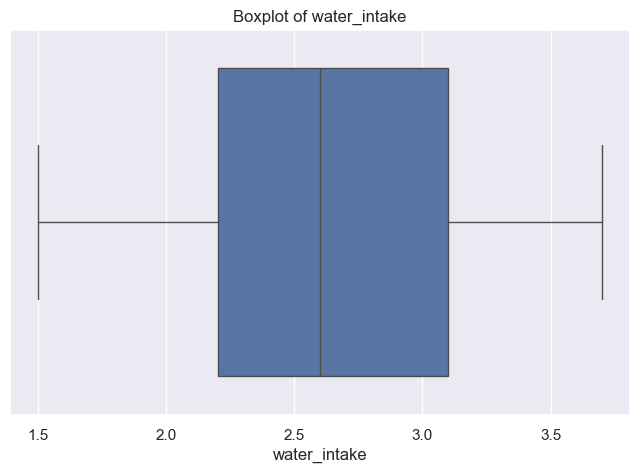

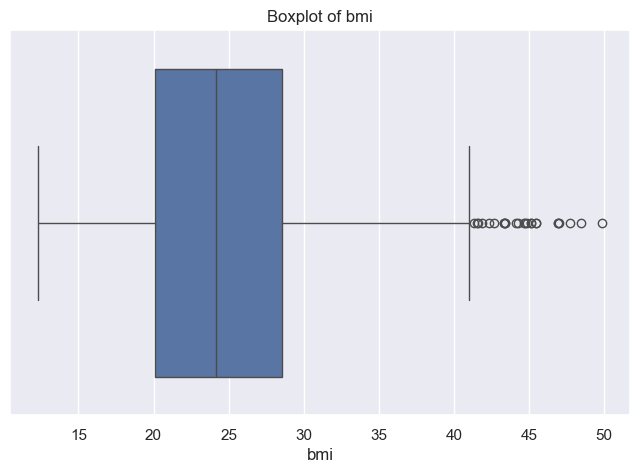

In [15]:
# Plot the boxplots
plot_boxplots(df, numerical_features)

In [16]:
# Selecting only numerical columns
numerical_columns = df.select_dtypes(include=[np.number])

In [17]:
# Calculating the Interquartile Range (IQR) for each numerical column
Q1 = numerical_columns.quantile(0.25)
Q3 = numerical_columns.quantile(0.75)
IQR = Q3 - Q1

# Defining the lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Finding outliers by checking if values fall outside the bounds
outliers = (numerical_columns < lower_bound) | (numerical_columns > upper_bound)

# Printing outliers for each numerical column
for column in outliers.columns:
    print(f"Outliers in {column}:")
    print(df[outliers[column]][column])
    print()

Outliers in age:
Series([], Name: age, dtype: int64)

Outliers in weight:
96     129.0
122    129.5
180    128.2
283    128.4
291    128.4
593    129.9
614    128.4
648    127.9
854    129.2
Name: weight, dtype: float64

Outliers in height:
Series([], Name: height, dtype: float64)

Outliers in max_bpm:
Series([], Name: max_bpm, dtype: int64)

Outliers in avg_bpm:
Series([], Name: avg_bpm, dtype: int64)

Outliers in resting_bpm:
Series([], Name: resting_bpm, dtype: int64)

Outliers in session_duration:
Series([], Name: session_duration, dtype: float64)

Outliers in calories_burned:
90     1688.0
99     1625.0
124    1701.0
475    1622.0
511    1725.0
572    1646.0
646    1675.0
712    1766.0
728    1634.0
910    1783.0
Name: calories_burned, dtype: float64

Outliers in fat_percentage:
Series([], Name: fat_percentage, dtype: float64)

Outliers in water_intake:
Series([], Name: water_intake, dtype: float64)

Outliers in workout_frequency:
Series([], Name: workout_frequency, dtype: int64)


In [18]:
# Calculating the number of outliers in each numerical column
num_outliers = outliers.sum()

# Computing the percentage of outliers in each numerical column
total_rows = df.shape[0]
percentage_outliers = (num_outliers / total_rows) * 100

# Creating a DataFrame to store the results
outlier_stats = pd.DataFrame({
    'Num_Outliers': num_outliers,
    'Percentage_Outliers': percentage_outliers
})

# Displaying the outlier statistics
print("Outlier Statistics:")
print(outlier_stats)

Outlier Statistics:
                   Num_Outliers  Percentage_Outliers
age                           0             0.000000
weight                        9             0.924974
height                        0             0.000000
max_bpm                       0             0.000000
avg_bpm                       0             0.000000
resting_bpm                   0             0.000000
session_duration              0             0.000000
calories_burned              10             1.027749
fat_percentage                0             0.000000
water_intake                  0             0.000000
workout_frequency             0             0.000000
experience_level              0             0.000000
bmi                          25             2.569373


**Outlier Statistics**

*Columns with Outliers:*
- Weight (kg): 9 outliers (~0.92% of data).
- Calories_Burned: 10 outliers (~1.03% of data).
- BMI: 25 outliers (~2.57% of data).

*Columns Without Outliers:*

- Age, Height (m), Max_BPM, Avg_BPM, Resting_BPM, Session_Duration (hours), Fat_Percentage, Water_Intake (liters), Workout_Frequency (days/week), Experience_Level.

In [19]:
# Function to visualize outliers
def visualize_outliers(data, column, lower_bound, upper_bound):
    plt.figure(figsize=(12, 6))

    # Scatter plot to show outliers
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=data.index, y=data[column], color="blue")
    plt.axhline(lower_bound[column], color="red", linestyle="--", label="Lower Bound")
    plt.axhline(upper_bound[column], color="green", linestyle="--", label="Upper Bound")
    plt.title(f"Scatter Plot of {column} (with Outliers)")
    plt.xlabel("Index")
    plt.ylabel(column)
    plt.legend()

    # Boxplot to visualize outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column], color="lightblue")
    plt.title(f"Boxplot of {column}")

    plt.tight_layout()
    plt.show()

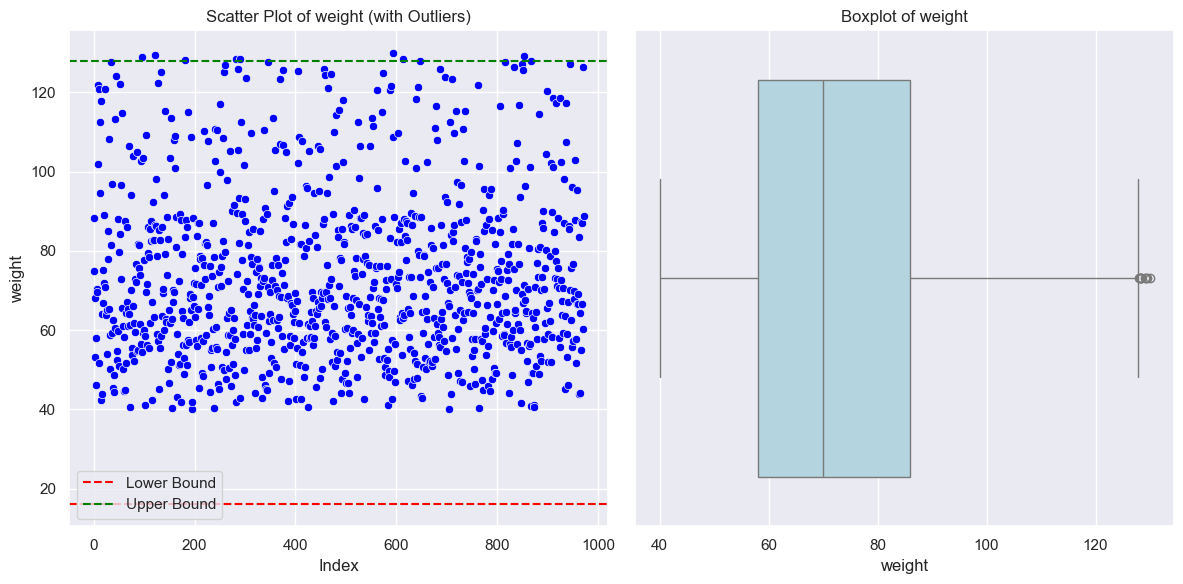

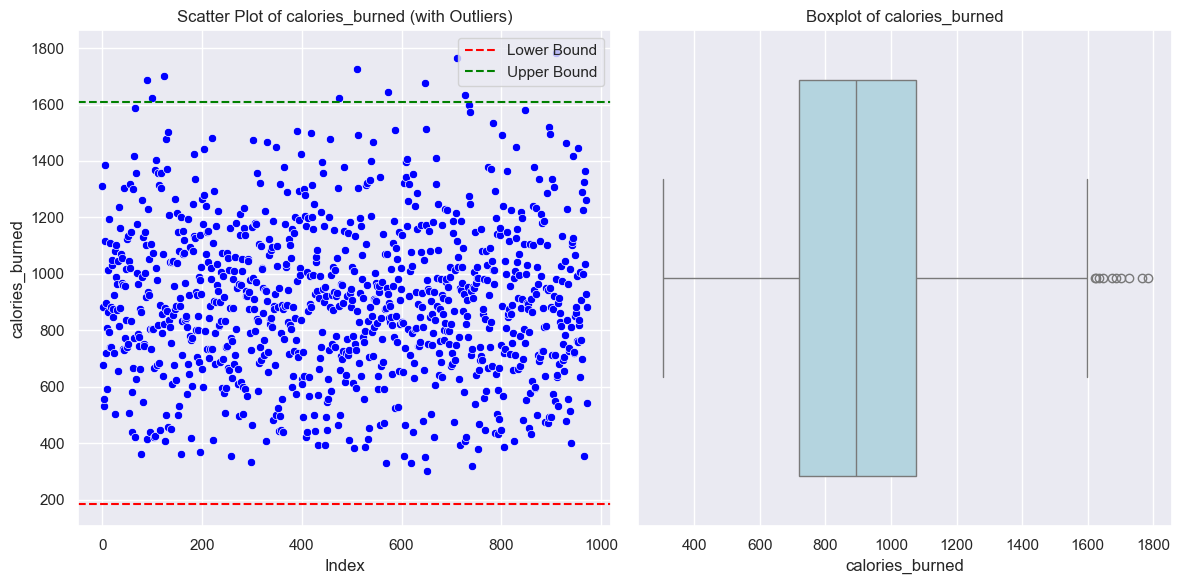

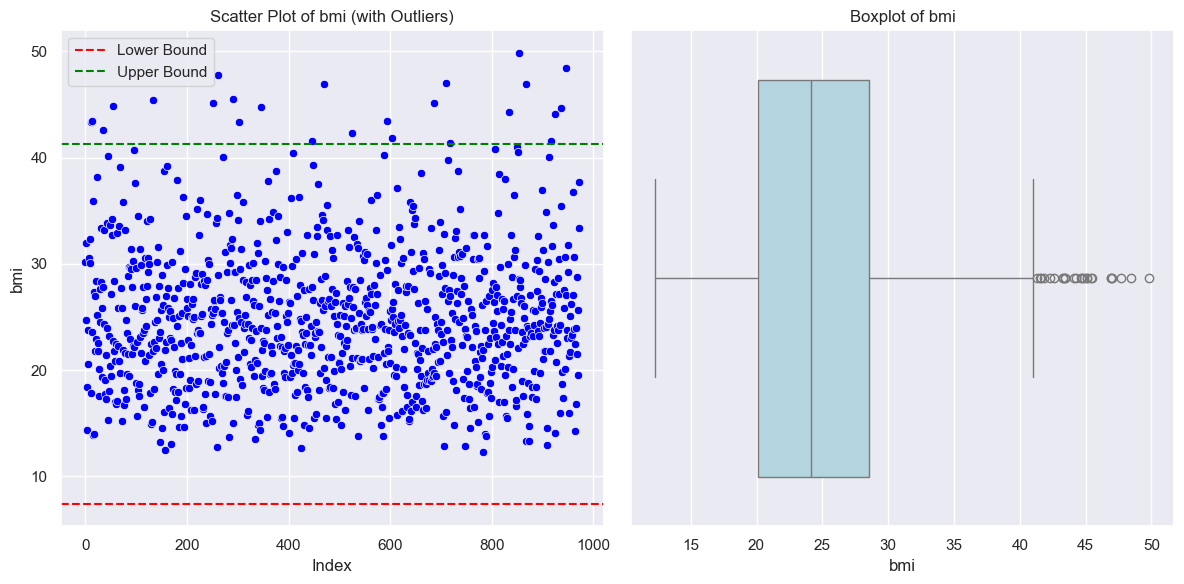

In [20]:
# Visualize outliers for affected columns
for col in ["weight", "calories_burned", "bmi"]:
    visualize_outliers(df, col, lower_bound, upper_bound)

## Feature Engineering

In [21]:
# Create a new feature: Heart Rate Difference (Max_BPM - Resting_BPM)
df['heart_rate_difference'] = df['max_bpm'] - df['resting_bpm']

In [22]:
# Check for missing values
df['heart_rate_difference'].isnull().sum()

0

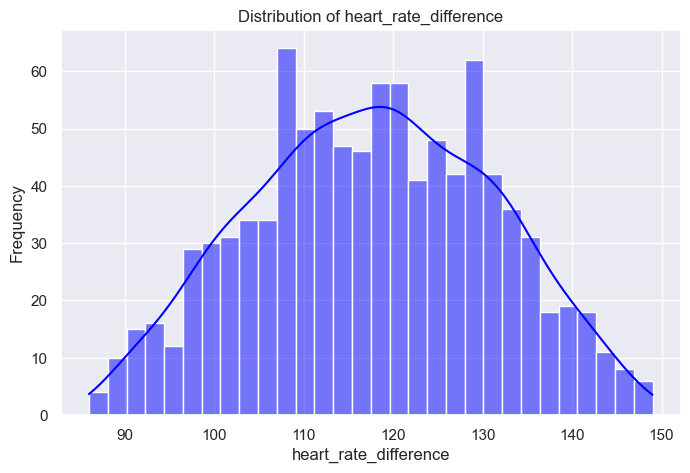

In [23]:
plot_distributions(df, ['heart_rate_difference'])

In [24]:
# Categorize BMI into groups: Underweight, Normal, Overweight, Obese
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 24.9:
        return 'Normal'
    elif 24.9 <= bmi < 29.9:
        return 'Overweight'
    else:
        return 'Obese'

df['bmi_category'] = df['bmi'].apply(categorize_bmi)

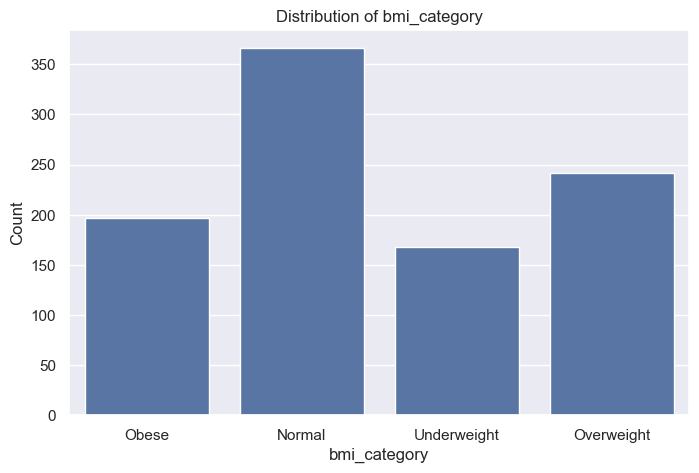

In [25]:
plot_categorical_distribution(df, 'bmi_category')

In [26]:
# Create a feature for Workout Intensity: Calories_Burned / Session_Duration
df['workout_intensity'] = df['calories_burned'] / df['session_duration']

In [27]:
# Check for missing values
df['workout_intensity'].isnull().sum()

0

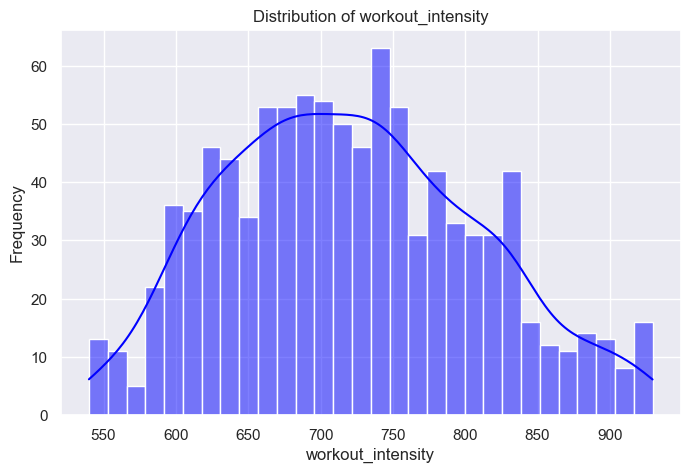

In [28]:
# Visualize the distribution
plot_distributions(df, ['workout_intensity'])

## Correlations

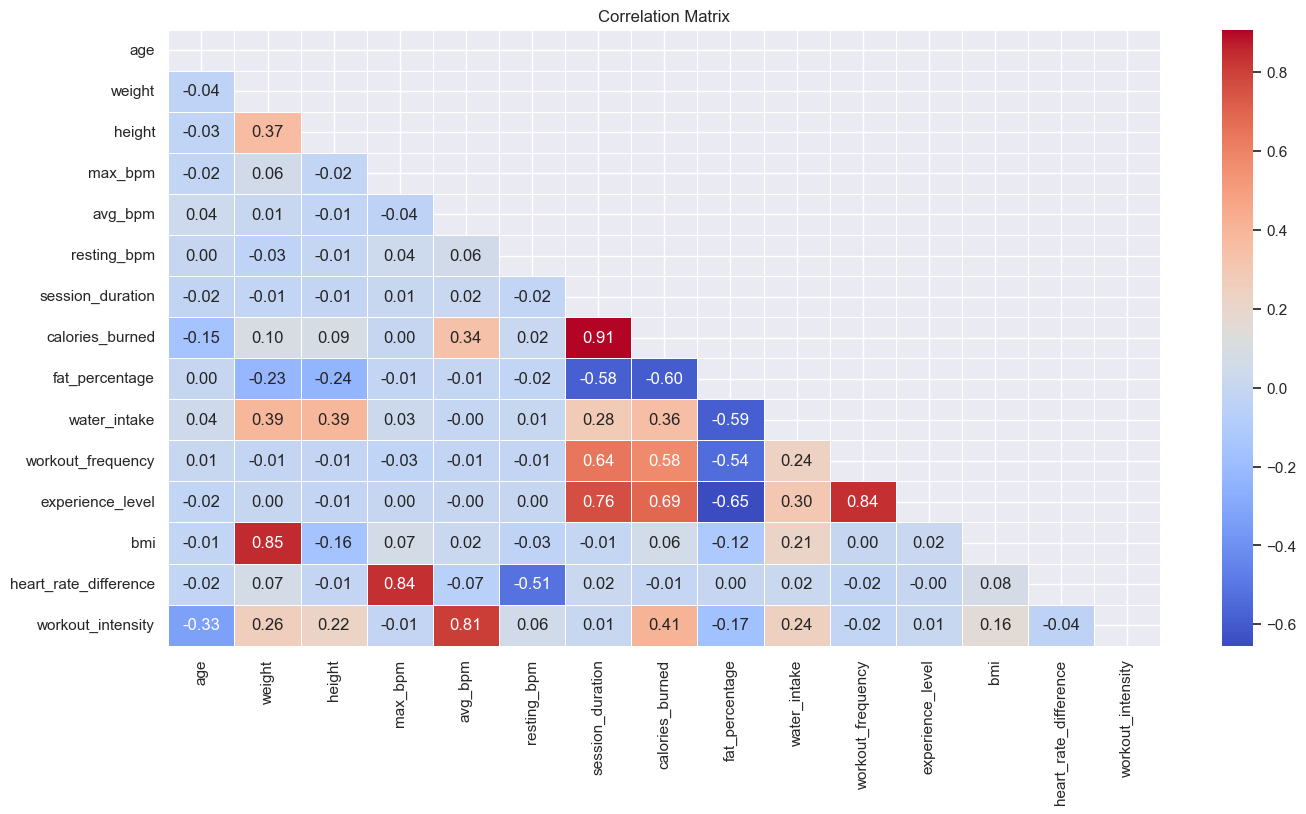

In [29]:
# Correlation Analysis
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(16, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [30]:
# Identify key correlated pairs (threshold > 0.7 for strong correlation)
correlation_threshold = 0.7
key_correlated_pairs = []

# Iterate over the correlation matrix and find pairs above the threshold
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            feature_1 = correlation_matrix.index[i]
            feature_2 = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]
            key_correlated_pairs.append((feature_1, feature_2, correlation_value))

# Convert to DataFrame for better readability and display
key_correlated_pairs_df = pd.DataFrame(key_correlated_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
key_correlated_pairs_df = key_correlated_pairs_df.sort_values(by="Correlation", ascending=False).reset_index(drop=True)

key_correlated_pairs_df

Feature 1              Feature 2  Correlation
0   session_duration        calories_burned     0.908140
1             weight                    bmi     0.853158
2            max_bpm  heart_rate_difference     0.838274
3  workout_frequency       experience_level     0.837079
4            avg_bpm      workout_intensity     0.810482
5   session_duration       experience_level     0.764768

These feature pairs exhibit strong correlations and could potentially cause multicollinearity in a predictive model.

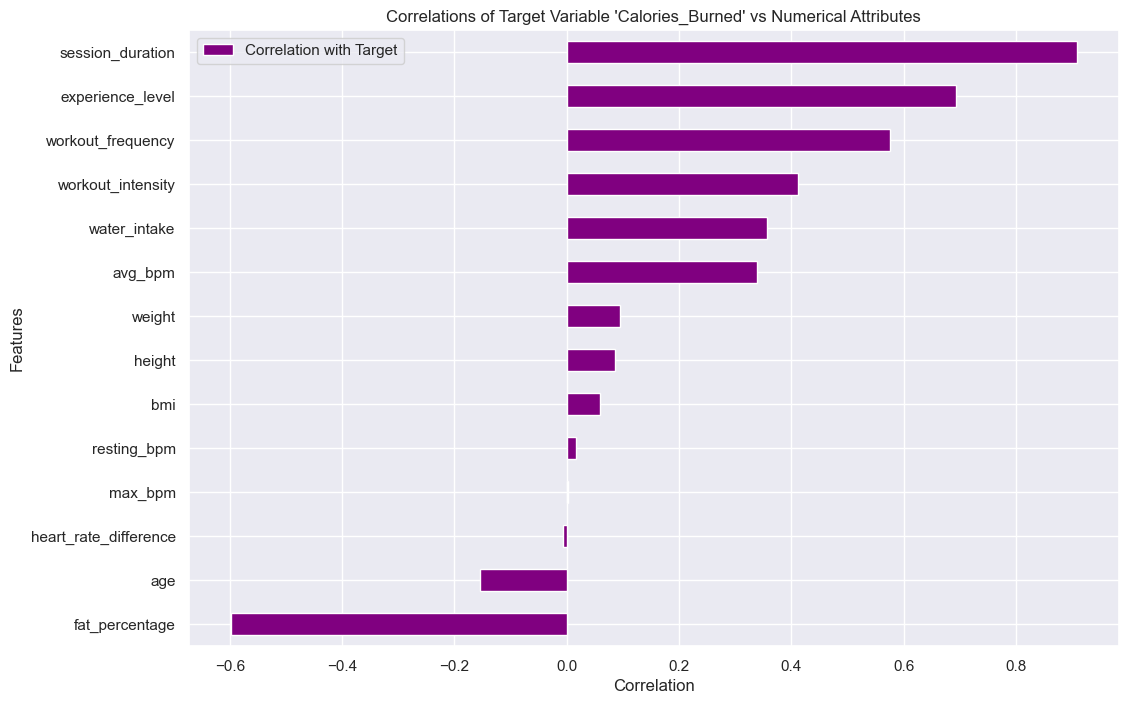

In [31]:
# Extract correlation values between each feature and the target variable 'days_active_first_28_days_after_registration'
target_correlation = correlation_matrix['calories_burned'].drop('calories_burned')

# Sort correlations by absolute value to see the strongest correlations at the top
target_correlation_sorted = target_correlation.sort_values(ascending=True).to_frame(name='Correlation with Target')

# Plotting the correlations
target_correlation_sorted.plot(kind='barh', figsize=(12,8), color='purple')
plt.title("Correlations of Target Variable 'Calories_Burned' vs Numerical Attributes")
plt.xlabel("Correlation")
plt.ylabel("Features")
plt.show()

**Insights**

*Highly Predictive Features:*

- Session_Duration (hours) is the strongest predictor (0.908).
- Experience_Level and Workout_Frequency (days/week) also have significant positive correlations.

*Negative Correlations:*

- Fat_Percentage has the strongest negative correlation with Calories_Burned (-0.598), indicating less efficient calorie burning for individuals with higher body fat percentages.

*Weak Predictors:*

- Features like Max_BPM, Resting_BPM, and Heart_Rate_Difference have negligible correlations with Calories_Burned and may not be useful for modeling.

**Key Observations**

- Session_Duration (hours) and Calories_Burned:

Strong positive correlation (0.908).
Retain both for now, as Calories_Burned is the target variable.

- Weight (kg) and BMI:

Highly correlated (0.853).
We choose one for modeling to reduce redundancy, likely BMI since it is a normalized measure.

- Max_BPM and Heart_Rate_Difference:

Strong correlation (0.838).
Retain one; Heart_Rate_Difference may capture exercise variability better.

- Workout_Frequency (days/week) and Experience_Level:

Strong correlation (0.837).
Retain both initially, as they may offer complementary information.

- Avg_BPM and Workout_Intensity:

Correlation (0.810).
Retain Workout_Intensity, as it combines multiple factors.

- Session_Duration (hours) and Experience_Level:

Correlation (0.765).
Both are important for modeling; retain for now.

In [32]:
# Dropping redundant features based on observations to handle multicollinearity
df_reduced = df.drop(columns=["weight", "max_bpm", "avg_bpm"])

# Verifying the remaining features
print("Remaining features after dropping redundant columns:")
df_reduced.columns

Remaining features after dropping redundant columns:


Index(['age', 'gender', 'height', 'resting_bpm', 'session_duration',
       'calories_burned', 'workout_type', 'fat_percentage', 'water_intake',
       'workout_frequency', 'experience_level', 'bmi', 'heart_rate_difference',
       'bmi_category', 'workout_intensity'],
      dtype='object')

In [33]:
# Identify categorical columns
categorical_columns = df_reduced.select_dtypes(include=["object"]).columns
categorical_columns

Index(['gender', 'workout_type', 'bmi_category'], dtype='object')

In [34]:
# Initialize one-hot encoder
encoder = OneHotEncoder(sparse_output=False, drop="first")

# Apply one-hot encoding to categorical columns
encoded_data = encoder.fit_transform(df_reduced[categorical_columns])

# Create a DataFrame for the encoded features
encoded_columns = encoder.get_feature_names_out(categorical_columns)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns)

# Drop original categorical columns and concatenate encoded features
df_encoded = pd.concat([df_reduced.drop(columns=categorical_columns), encoded_df], axis=1)

# Display the first few rows of the encoded dataset
print("Encoded Dataset:")
df_encoded.head()

Encoded Dataset:


age  height  resting_bpm  session_duration  calories_burned  \
0   56    1.71           60              1.69           1313.0   
1   46    1.53           66              1.30            883.0   
2   32    1.66           54              1.11            677.0   
3   25    1.70           56              0.59            532.0   
4   38    1.79           68              0.64            556.0   

   fat_percentage  water_intake  workout_frequency  experience_level    bmi  \
0            12.6           3.5                  4                 3  30.20   
1            33.9           2.1                  4                 2  32.00   
2            33.4           2.3                  4                 2  24.71   
3            28.8           2.1                  3                 1  18.41   
4            29.2           2.8                  3                 1  14.39   

   heart_rate_difference  workout_intensity  gender_Male  workout_type_HIIT  \
0                    120         776.923077          1.0                0.0   
1                    113         679.230769          0.0                1.0   
2                    113         609.909910          0.0                0.0   
3                    134         901.694915          1.0                0.0   
4                    120         868.750000          1.0                0.0   

   workout_type_Strength  workout_type_Yoga  bmi_category_Obese  \
0                    0.0                1.0                 1.0   
1                    0.0                0.0                 1.0   
2                    0.0                0.0                 0.0   
3                    1.0                0.0                 0.0   
4                    1.0                0.0                 0.0   

   bmi_category_Overweight  bmi_category_Underweight  
0                      0.0                       0.0  
1                      0.0                       0.0  
2                      0.0                       0.0  
3                      0.0                       1.0  
4                      0.0                       1.0

In [35]:
# Define the desired path for the processed data folder
processed_data_folder = r"C:\Users\User\ml-zoomcamp\midterm_project\data\processed"

# Ensure the processed data folder exists
os.makedirs(processed_data_folder, exist_ok=True)

# Save the encoded dataset
df_encoded.to_csv(r"C:\Users\User\ml-zoomcamp\midterm_project\data\processed\encoded_data.csv", index=False)

In [36]:
# Define the target and features
X = df_encoded.drop(columns=['calories_burned'], errors='ignore')
y = df_encoded['calories_burned']

# Split the data with shuffling enabled for feature selection
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model using only the training set
rf_model.fit(X_train, y_train)

# Get feature importance from the Random Forest model
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Initialize RFE with the Random Forest model as the estimator
rfe_selector = RFE(estimator=rf_model, n_features_to_select=10, step=1)
rfe_selector.fit(X_train, y_train)

# Get the ranking of features from RFE
rfe_features = pd.DataFrame({
    'Feature': X_train.columns,
    'RFE_Ranking': rfe_selector.ranking_
}).sort_values(by='RFE_Ranking')

# Merge feature importance and RFE rankings for comparison
feature_selection_summary = pd.merge(feature_importances, rfe_features, on='Feature')

# Select features with RFE rank 1
selected_features = feature_selection_summary[
    feature_selection_summary['RFE_Ranking'] == 1
]['Feature'].tolist()

print("Selected Features:", selected_features)

Selected Features: ['session_duration', 'workout_intensity', 'fat_percentage', 'bmi', 'heart_rate_difference', 'age', 'height', 'resting_bpm', 'water_intake', 'workout_frequency']


In [69]:
# Save selected features
selected_features_path = r"C:\Users\User\ml-zoomcamp\midterm_project\models\selected_features.json"
with open(selected_features_path, 'w') as file:
    json.dump(selected_features, file)

In [37]:
# Define the target and features
X = df_encoded[selected_features]
y = df_encoded['calories_burned']

# Split data into initial train+val (80%) and test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Split the remaining data into train (64%) and validation (16%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, shuffle=True)

# Display the shapes of the splits to verify
print("Train set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Train set size: (622, 10)
Validation set size: (156, 10)
Test set size: (195, 10)


In [39]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform train, validation, and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Check the shapes of the scaled data
print("Scaled Train set size:", X_train_scaled.shape)
print("Scaled Validation set size:", X_val_scaled.shape)
print("Scaled Test set size:", X_test_scaled.shape)

Scaled Train set size: (622, 10)
Scaled Validation set size: (156, 10)
Scaled Test set size: (195, 10)


In [40]:
# Save the scaler
scaler_path = os.path.join(processed_data_folder, 'scaler.pkl')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved at: {scaler_path}")

Scaler saved at: C:\Users\User\ml-zoomcamp\midterm_project\data\processed\scaler.pkl


In [41]:
# Save the scaled data
X_train_scaled_path = os.path.join(processed_data_folder, 'X_train_scaled.npy')
np.save(X_train_scaled_path, X_train_scaled)
print(f"X_train_scaled saved at: {X_train_scaled_path}")

y_train_path = os.path.join(processed_data_folder, 'y_train.npy')
np.save(y_train_path, y_train)
print(f"y_train saved at: {y_train_path}")

X_val_scaled_path = os.path.join(processed_data_folder, 'X_val_scaled.npy')
np.save(X_val_scaled_path, X_val_scaled)
print(f"X_val_scaled saved at: {X_val_scaled_path}")

y_val_path = os.path.join(processed_data_folder, 'y_val.npy')
np.save(y_val_path, y_val)
print(f"y_val saved at: {y_val_path}")

X_test_scaled_path = os.path.join(processed_data_folder, 'X_test_scaled.npy')
np.save(X_test_scaled_path, X_test_scaled)
print(f"X_test_scaled saved at: {X_test_scaled_path}")

y_test_path = os.path.join(processed_data_folder, 'y_test.npy')
np.save(y_test_path, y_test)
print(f"y_test saved at: {y_test_path}")

X_train_scaled saved at: C:\Users\User\ml-zoomcamp\midterm_project\data\processed\X_train_scaled.npy
y_train saved at: C:\Users\User\ml-zoomcamp\midterm_project\data\processed\y_train.npy
X_val_scaled saved at: C:\Users\User\ml-zoomcamp\midterm_project\data\processed\X_val_scaled.npy
y_val saved at: C:\Users\User\ml-zoomcamp\midterm_project\data\processed\y_val.npy
X_test_scaled saved at: C:\Users\User\ml-zoomcamp\midterm_project\data\processed\X_test_scaled.npy
y_test saved at: C:\Users\User\ml-zoomcamp\midterm_project\data\processed\y_test.npy


In [ ]:
# Initialize LOOCV
loo = LeaveOneOut()

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(random_state=42, n_estimators=100, force_col_wise=True),
    "CatBoost": CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, verbose=0, random_state=42)
}

# Evaluate each model using LOOCV
results = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    predictions = []
    true_values = []
    for train_index, test_index in loo.split(X_train_scaled):
        X_train_split, X_test_split = X_train_scaled[train_index], X_train_scaled[test_index]
        y_train_split, y_test_split = y_train.values[train_index], y_train.values[test_index]
        
        model.fit(X_train_split, y_train_split)
        pred = model.predict(X_test_split)
        
        predictions.append(pred[0])
        true_values.append(y_test_split[0])
    
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    results[name] = rmse

# Display LOOCV results
results = dict(sorted(results.items(), key=lambda x: x[1]))
print("Model Performance (LOOCV - RMSE):")
for model_name, rmse in results.items():
    print(f"{model_name}: {rmse:.2f}")

Evaluating Linear Regression...
Evaluating Ridge Regression...
Evaluating Lasso Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating Support Vector Regressor...
Evaluating XGBoost...
Evaluating LightGBM...
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 10
[LightGBM] [Info] Start training from score 897.892110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

In [ ]:
# Convert to a Dataframe
pd.DataFrame(results.items(), columns=(["Model","RMSE"]))

Model        RMSE
0                  CatBoost   15.907967
1         Gradient Boosting   18.088608
2                  LightGBM   21.222545
3                   XGBoost   21.809312
4             Random Forest   24.102646
5          Lasso Regression   31.209429
6         Linear Regression   31.286146
7          Ridge Regression   31.290721
8             Decision Tree   42.616513
9  Support Vector Regressor  244.951918

In [45]:
# Find the best model based on the lowest RMSE
best_model_name = min(results, key=results.get)
best_model_rmse = results[best_model_name]

print("\nBest Model Based on LOOCV:")
print(f"Model: {best_model_name}")
print(f"RMSE: {best_model_rmse:.2f}")


Best Model Based on LOOCV:
Model: CatBoost
RMSE: 15.91


## Hyperparameter Tuning

In [ ]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 500, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "random_state": 42,
        "verbose": 0
    }

    # Train CatBoost
    model = CatBoostRegressor(**params)
    model.fit(X_train_scaled, y_train, eval_set=(X_val_scaled, y_val), early_stopping_rounds=50)

    # Predict and calculate RMSE
    y_pred = model.predict(X_val_scaled)
    rmse = root_mean_squared_error(y_val, y_pred)
    return rmse

In [52]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2024-11-25 13:14:50,083] A new study created in memory with name: no-name-50aec424-1c3e-4c31-a787-457ef1f75fd1
[I 2024-11-25 13:14:54,566] Trial 0 finished with value: 16.653776745099854 and parameters: {'iterations': 1027, 'learning_rate': 0.026116087710887165, 'depth': 6, 'l2_leaf_reg': 7.494472514242595, 'subsample': 0.8147449335325286}. Best is trial 0 with value: 16.653776745099854.
[I 2024-11-25 13:15:06,237] Trial 1 finished with value: 28.264563678862782 and parameters: {'iterations': 1249, 'learning_rate': 0.09107471034588371, 'depth': 9, 'l2_leaf_reg': 8.987437304418197, 'subsample': 0.8109117980856633}. Best is trial 0 with value: 16.653776745099854.
[I 2024-11-25 13:15:08,239] Trial 2 finished with value: 19.337627070433623 and parameters: {'iterations': 533, 'learning_rate': 0.13663376734975166, 'depth': 6, 'l2_leaf_reg': 6.211172241622744, 'subsample': 0.6663144935740694}. Best is trial 0 with value: 16.653776745099854.
[I 2024-11-25 13:15:10,987] Trial 3 finished with

Best hyperparameters: {'iterations': 1265, 'learning_rate': 0.03683058312225691, 'depth': 4, 'l2_leaf_reg': 3.439909532563939, 'subsample': 0.9569762204547745}
Best RMSE: 9.413565262595721


In [63]:
# Define the folder path
folder_path = r'C:\Users\User\ml-zoomcamp\midterm_project\models'

# Save the best hyperparameters
best_hyperparams = study.best_params
file_path = os.path.join(folder_path, 'best_hyperparams.json')
with open(file_path, 'w') as file:
    json.dump(best_hyperparams, file)

print(f"Best hyperparameters saved to '{file_path}'.")

Best hyperparameters saved to 'C:\Users\User\ml-zoomcamp\midterm_project\models\best_hyperparams.json'.


In [64]:
# Combine training and validation datasets
X_final_train = np.vstack([X_train_scaled, X_val_scaled])
y_final_train = np.hstack([y_train, y_val])

# Train the final model
final_model = CatBoostRegressor(
    iterations=best_hyperparams['iterations'],
    learning_rate=best_hyperparams['learning_rate'],
    depth=best_hyperparams['depth'],
    l2_leaf_reg=best_hyperparams['l2_leaf_reg'],
    subsample=best_hyperparams['subsample'],
    verbose=0,
    random_state=42
)

final_model.fit(X_final_train, y_final_train)

In [65]:
# Save the final model
joblib.dump(final_model, 'C:/Users/User/ml-zoomcamp/midterm_project/models/catboost_model.pkl')
print("Final model saved as 'C:/Users/User/ml-zoomcamp/midterm_project/models/catboost_model.pkl'.")

Final model saved as 'C:/Users/User/ml-zoomcamp/midterm_project/models/catboost_model.pkl'.


## Model Evaluation

In [67]:
# Predict on the test set
test_predictions = final_model.predict(X_test_scaled)

# Evaluate performance on the test set
test_rmse = root_mean_squared_error(y_test, test_predictions)
print(f"Final Test RMSE: {test_rmse:.4f}")

Final Test RMSE: 8.1323


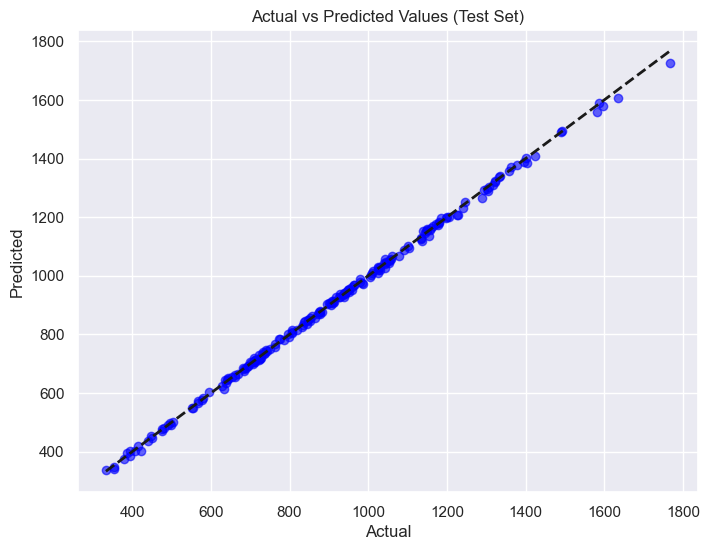

In [68]:
# Plot predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_predictions, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values (Test Set)')
plt.show()

### Transition to `train.py`

The notebook has identified the best model and hyperparameters using Optuna. It trained the final CatBoost model on the combined training and validation data. The final model was evaluated on the test set, achieving a RMSE of 8.132.

The next steps in `train.py`:
1. Load the training data and saved hyperparameters (`best_hyperparams.json`).
2. Train the CatBoost model using the optimal hyperparameters.
3. Save the final trained model for deployment.
